# Evaluating the Predictive Capabilities of "Predictive Testing"
## Predicting NCLEX Success for Nursing Students
Author: Alexander Stachniak

# Model Building and Analysis Stage
As we begin fitting our data to determine the best model, we should understand which metrics will be used in evaluation. First, we will use hyperparameter tuning to help find the best set of parameters for various models (e.g. l1 or l2 penalty for Logistic Regression). Within those tests, we will rely on F1-Weighted score to determine the best set of parameters. F1-Weighted score helps to balance between precision and recall for both the minority and majority class, important when we have such a large class imbalance.

To compare between model types, we will review Confusion Matrices and Classification Reports as a way to understand the relative strengths and weaknesses of each model. Of special importance to us will be recall of the minority class (i.e. we want to catch as many future failures as we can) and precision of the majority class (i.e. we don't want to mistakenly predict that remediation is not necessary for a student who eventually fails).


## Goals
* Fit data using a variety of predictive modeling techniques
* Based on appropriate evaluation metrics, determine the best predictive model for our data
* Analyze the results

# Modules
All Python modules used are fairly common and will be installed as a default for users running Anaconda.

### Exception: probability_boundary
The probability_boundary library is a self-built class that calculates probability boundary scores and has its own plotting method. Here we import to Jupyter Notebook using the %run magic function.

### Exception: imblearn
The exception is imblearn, an open source implementation of sampling methods (http://contrib.scikit-learn.org/imbalanced-learn/index.html). This project makes use of imblearn's implementation of SMOTE.
#### Installation is simple:
pip install -U imbalanced-learn

In [1]:
# Standard modules
import pandas as pd
import numpy as np
import pickle
import datetime

# Import probability_boundary Library
%run probability_boundary.py

# Plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Display plots within Jupyter Notebook
%matplotlib inline
# Set default plot size
plt.rcParams['figure.figsize'] = (14, 5)
# Seaborn used for its excellent correlation heatmap plot
import seaborn as sns

# SciKit Learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import scale, Imputer, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score, make_scorer, average_precision_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC

# One module from SciPy used for calculating percentile scores
from scipy.stats import percentileofscore

# An open source implementation of sampling methods
# http://contrib.scikit-learn.org/imbalanced-learn/index.html
from imblearn.over_sampling import SMOTE

# For display of mathematical formulae
from IPython.display import Math

# Caution: use only when certain of results
import warnings
warnings.filterwarnings('ignore')

# Functions to Assist in Model Building
The functions below are designed to standardize the model building process to make evaluation and comparison much easier. 

In [2]:
def print_confusion_matrix (cm, labels):
    '''A pretty-print function for a confusion matrix of any size.'''
    types = ['Predicted', 'Actual']
    # Find number of edges in matrix
    edges = cm.shape[0]
    # Find maximum printed width
    max_width = len(max(types, key=len) + ': ' + max(labels, key=len)) + 2
    # Create a dynamix print statement
    formatting = '{:^' + str(max_width) + '}'
    print_statement = ''.join([formatting for edge in range(edges+1)])
    # Iterate through edges to create dynamic list of arguments
    for i in range(edges + 1):
        print_arguments = []
        if i == 0:
            print_arguments.append('')
            print_arguments.extend([types[0] + ': ' + labels[x] for x in range(edges)])
        else:
            print_arguments.append(types[1] + ': ' + labels[i-1])
            print_arguments.extend(cm[i-1][[x for x in range(edges)]])
        # Pretty printing
        print(print_statement.format(*print_arguments))

In [3]:
def plot_roc_auc (y_true, y_pred, pos_label=1, width=14, height=5, subplot=111, color='blue'):
    '''Function produces a plot of Receiver Operating Characteristic (ROC)
    Area Under the Curve (AUC) using functions from SciKit Learn.
    
    @ Parameters:
    ------------------
        y_true: array of true class values
        y_pred: array of probability scores for positive class
        pos_label: label considered as positive (default=1)
        width: width of plot in inches
        height: height of plot in inches
        subplot: three-digit shorthand for subplot
        color: color of ROC AUC line
        
    @ Return:
    ------------------
        roc_auc: the area under the curve
    '''

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
        
    # Set default plot size
    plt.rcParams['figure.figsize'] = (width, height)
    plt.subplot(subplot)
    # Plot ROC Curve
    plt.plot(fpr, tpr, color=color, lw=2, alpha=0.6, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    # Plot the "luck" line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Blind Luck')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)\nArea Under the Curve (AUC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [33]:
def combine_probs_by_term (data_dict, terms, model_name):
    '''Gathers prediction probabilities into a single array, organized by observation.
    
    @ Parameters:
    ------------------
        data_dict: name of data dictionary
        terms: list of term values
        location: string name indicating dictionary storage location of prediction probabilities
    '''
    # For each term, append probability scores to temp_df
    for term in terms:
        if term == 1:
            temp_df = np.array(data_dict[term][model_name]['pred_prob'][:,1])
        else:
            temp_df = np.vstack((temp_df, data_dict[term][model_name]['pred_prob'][:,1]))
    # Transpose shape
    temp_df = np.transpose(temp_df)
    return temp_df

In [54]:
def plot_violins (terms, y_pred_prob, y_true, colors=['#d62728', '#1f77b4']):
    '''Creates violin plots of the probability distribution in the classes.
    
    @ Parameters:
    ------------------
        y_pred_prob: array of probability scores
        y_true: array of true class values
        colors: list of colors to use for classes
    '''
    # Determine classes
    classes = np.unique(y_true)
    # Iterate through classes
    for cls in classes:
        # Use only the values in the specified class
        values = y_pred_prob[np.where(y_true == cls)]
        # Plot it
        violin = plt.violinplot(values, showmeans=False, showmedians=True)
        # Set face colors
        for item in violin['bodies']:
            item.set_alpha(0.4)
            item.set_color(colors[cls])
        # Set line colors
        for item in ('cbars','cmins','cmaxes','cmedians'):
            vp = violin[item]
            vp.set_edgecolor(colors[cls])
            vp.set_linewidth(1)
        # Set plot labels
        plt.xticks(terms)
        plt.xlabel('Term')
        plt.ylabel('Probability of Passing')
        plt.title('Distribution of the Predicted Probability of Passing for Class {}'.format(str(cls)))
        plt.grid()
        plt.show()

In [71]:
def plot_error_bars (terms, y_pred_prob, y_true, colors=['#d62728', '#1f77b4']):
    '''Plots the average probability of each class, term by term, along with one
    standard deviation of error on either side.
    
    @ Parameters:
    ------------------
        terms: an ordered array of terms
        y_pred_prob: array of probability scores
        y_true: array of true class values
        colors: list of colors to use for classes
    '''
    # Determine classes
    classes = np.unique(y_true)
    # Determine appropriate shape
    shape = y_pred_prob.shape[1]
    for c in classes:
        # Use only the values in the specified class
        values = y_pred_prob[np.where(y_true == c)]
        # Initialize arrays for mean and one standard deviation
        y_avg = np.zeros(shape)
        y_err = np.zeros(shape)
        # Iterate through terms
        for term in range(shape):
            # Determine mean and standard deviation
            y_avg[term] = np.mean(values[:,term])
            y_err[term] = np.std(values[:,term])
        # Plot line and fill bars
        plt.plot(terms, y_avg, color=colors[c], marker='o', markersize=5, label='Class {}'.format(classes[c]))
        plt.fill_between(terms, y_avg + y_err, y_avg - y_err, alpha=0.4, color=colors[c])
    # Set plot options
    plt.ylim([0,1.0])
    plt.xticks(terms)
    plt.title('Average Predicted Probability of Passing +/- 1 Standard Deviation')
    plt.xlabel('Term')
    plt.ylabel('Probability of Passing')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [72]:
def plot_cross_validation (terms, train_mean, train_std, test_mean, test_std, scoring_name):
    '''Function displays a cross validation plot showing the associationed between training
    and testing data, as well as an indication of one standard deviation in either direction.
    
    @ Parameters:
    ------------------
        terms: an ordered array of terms
        train_mean: an array of scoring means for training data (one for each term)
        train_std: an array of standard deviations for training data (one for each term)
        test_mean: an array of scoring means for testing data (one for each term)
        test_std: an array of standard deviations for testing data (one for each term)
        scoring_name: A string representation of the scoring function used
    '''
    
    # Plot the training and validation scores with standard deviation
    plt.plot(terms, train_mean, color='blue', marker='o', markersize=5, label='Training ' + scoring_name)
    plt.fill_between(terms, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(terms, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation ' + scoring_name)
    plt.fill_between(terms, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    # Set y axis range to keep on same scale
    plt.ylim([0.60,1.00])
    plt.xticks(terms)
    plt.grid()
    plt.title('Cross Validation Scores')
    plt.xlabel('Term')
    plt.ylabel(scoring_name + ' score')
    plt.legend(loc='best')
    plt.show()

In [61]:
def fit_models (data_dict, x, y, val_x, val_y, clf_model, clf_params, scoring_method, class_labels):
    '''Function takes as input our data dictionary, model, and scoring function and outputs
    various scoring metrics, including confusion matrix and classification report, and also
    plots the probability boundaries of our classifier as well as an overall cross-validation
    plot.'''
    # Initialize GridSearchCV
    clf_gs = GridSearchCV(clf_model,param_grid=clf_params,cv=5,scoring=scoring_method)
    
    # Set name of prediction model
    model_name = clf_model.__class__.__name__    
    
    # Get terms
    terms = list(data_dict.keys())
    terms.sort()
    max_term = terms[-1]
    
    print('Model:', model_name)
    for term in terms:
        # Initialize dictionary
        data_dict[term][model_name] = {}
        # Fit the data
        print('Term:', term)
        clf_gs.fit(data_dict[term][x], data_dict[term][y])
        print('Best Score: {0:5.2f}%'.format(clf_gs.best_score_*100))
        print('Best Estimator:', clf_gs.best_estimator_)
        data_dict[term][model_name]['estimator'] = clf_gs.best_estimator_        
        # Fit the best estimator and make predictions
        data_dict[term][model_name]['estimator'].fit(data_dict[term][x], data_dict[term][y])
        data_dict[term][model_name]['pred'] = data_dict[term][model_name]['estimator'].predict(data_dict[term][val_x])
        data_dict[term][model_name]['pred_prob'] = data_dict[term][model_name]['estimator'].predict_proba(data_dict[term][val_x])
        data_dict[term][model_name]['train_scores'] = cross_val_score(data_dict[term][model_name]['estimator'], data_dict[term][x], data_dict[term][y], cv=5, scoring=scoring_method)
        data_dict[term][model_name]['test_scores'] = cross_val_score(data_dict[term][model_name]['estimator'], data_dict[term][val_x], data_dict[term][val_y], cv=5, scoring=scoring_method)
        
        # Print results
        print('\nConfusion Matrix:')
        cm = confusion_matrix(data_dict[term][val_y], data_dict[term][model_name]['pred'])
        print_confusion_matrix (cm, class_labels)
        print('\nClassification Report:')
        print(classification_report(data_dict[term][val_y], data_dict[term][model_name]['pred']))
        # Plot probability boundaries
        pb = probability_boundary(data_dict[term][model_name]['pred_prob'], data_dict[term][val_y])
        pb.plot(subplot=121)
        # Plot ROC AUC
        roc_auc = plot_roc_auc(data_dict[term][val_y], data_dict[term][model_name]['pred_prob'][:,1], subplot=122)
        
        # Make list of terms up to the current one
        data_dict[term][model_name]['terms'] = np.arange(1,term+1)
        # Save current scoring method
        data_dict[term][model_name]['scoring_method'] = scoring_method
        
        # Gather means and standard deviations using list comprehension
        data_dict[term][model_name]['train_mean'] = np.array([np.mean(data_dict[x][model_name]['train_scores']) for x in data_dict[term][model_name]['terms']])
        data_dict[term][model_name]['train_std'] = np.array([np.std(data_dict[x][model_name]['train_scores']) for x in data_dict[term][model_name]['terms']])
        data_dict[term][model_name]['test_mean'] = np.array([np.mean(data_dict[x][model_name]['test_scores']) for x in data_dict[term][model_name]['terms']])
        data_dict[term][model_name]['test_std'] = np.array([np.std(data_dict[x][model_name]['test_scores']) for x in data_dict[term][model_name]['terms']])
        
        # Gather prediction probabilities into a single array, organized by observation
        data_dict[term][model_name]['combined_probs'] = combine_probs_by_term(data_dict, data_dict[term][model_name]['terms'], model_name)
        data_dict[term][model_name]['target'] = np.array(data_dict[term][val_y])
    
    # Plot summary graphs
    # Violin plots
    plot_violins(terms, data_dict[max_term][model_name]['combined_probs'], data_dict[max_term][model_name]['target'])
    # Plot error bars
    plot_error_bars(terms, data_dict[max_term][model_name]['combined_probs'], data_dict[max_term][model_name]['target'])
    # Plot the training and validation scores with standard deviation
    plot_cross_validation (terms, data_dict[max_term][model_name]['train_mean'], data_dict[max_term][model_name]['train_std'], data_dict[max_term][model_name]['test_mean'], data_dict[max_term][model_name]['test_std'], data_dict[max_term][model_name]['scoring_method'])

# Load Data

In [62]:
with open('df_dict.pickle', 'rb') as file:
    df_dict = pickle.load(file)

In [63]:
class_labels = ['Fail', 'Pass']

Model: LogisticRegression
Term: 1
Best Score: 79.88%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          16                3        
  Actual: Pass          28               92        

Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.84      0.51        19
          1       0.97      0.77      0.86       120

avg / total       0.89      0.78      0.81       139



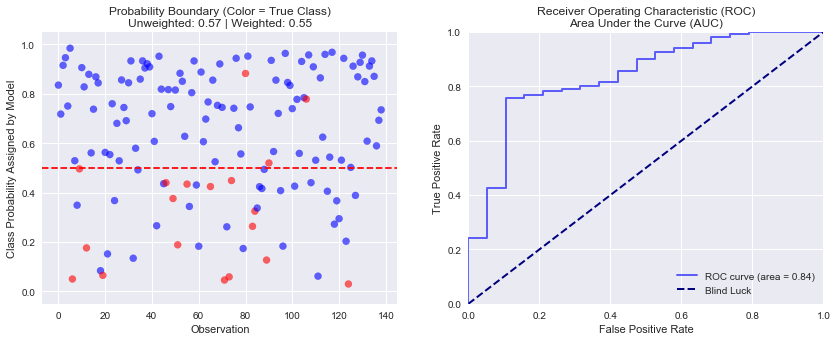

Term: 2
Best Score: 79.58%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          13                6        
  Actual: Pass          29               91        

Classification Report:
             precision    recall  f1-score   support

          0       0.31      0.68      0.43        19
          1       0.94      0.76      0.84       120

avg / total       0.85      0.75      0.78       139



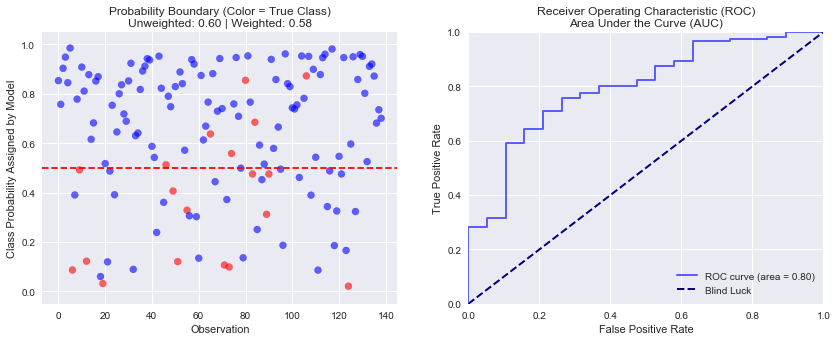

Term: 3
Best Score: 80.76%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          11                8        
  Actual: Pass          24               96        

Classification Report:
             precision    recall  f1-score   support

          0       0.31      0.58      0.41        19
          1       0.92      0.80      0.86       120

avg / total       0.84      0.77      0.80       139



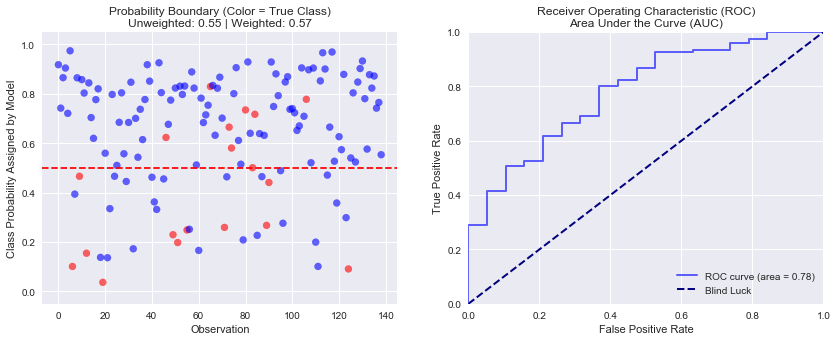

Term: 4
Best Score: 80.63%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          13                6        
  Actual: Pass          23               97        

Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.68      0.47        19
          1       0.94      0.81      0.87       120

avg / total       0.86      0.79      0.82       139



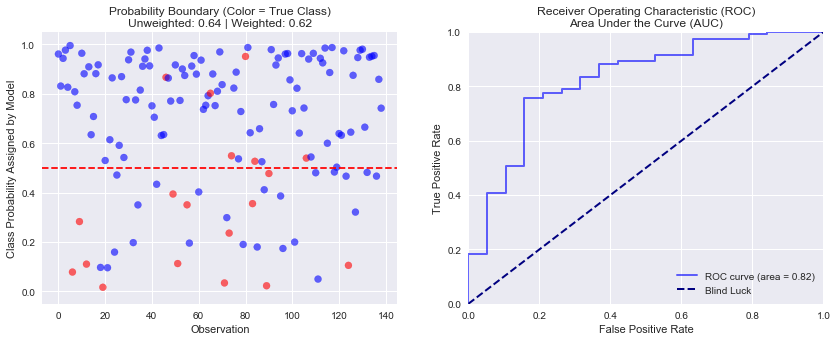

Term: 5
Best Score: 82.04%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           9               10        
  Actual: Pass          23               97        

Classification Report:
             precision    recall  f1-score   support

          0       0.28      0.47      0.35        19
          1       0.91      0.81      0.85       120

avg / total       0.82      0.76      0.79       139



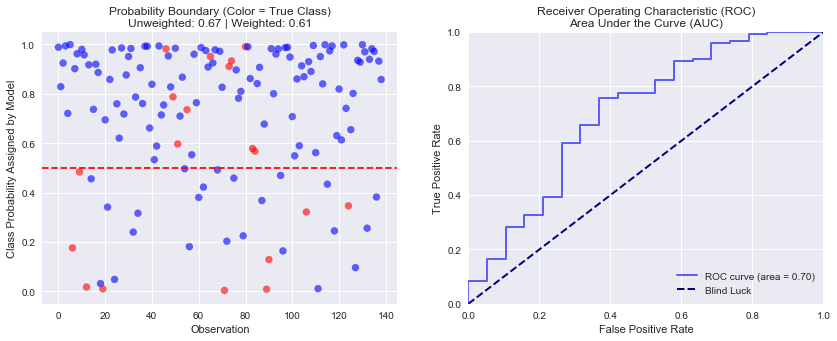

Term: 6
Best Score: 80.98%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          25               95        

Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139



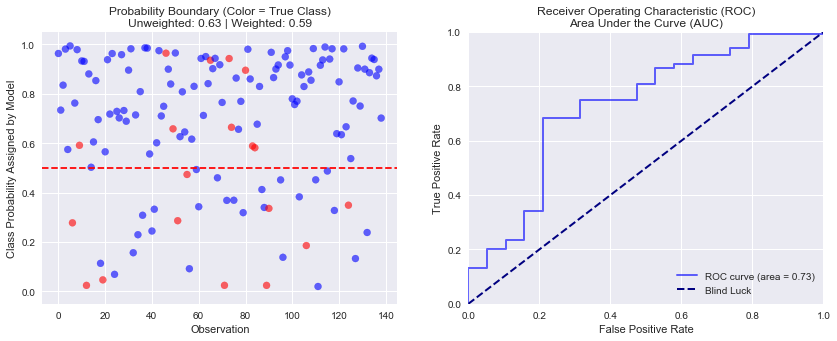

Term: 7
Best Score: 81.35%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          25               95        

Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139



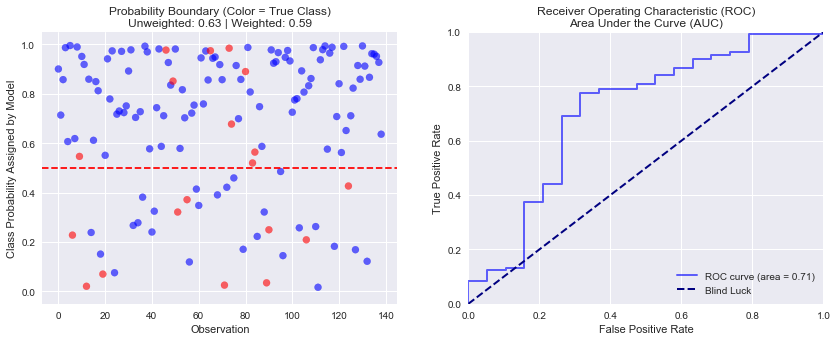

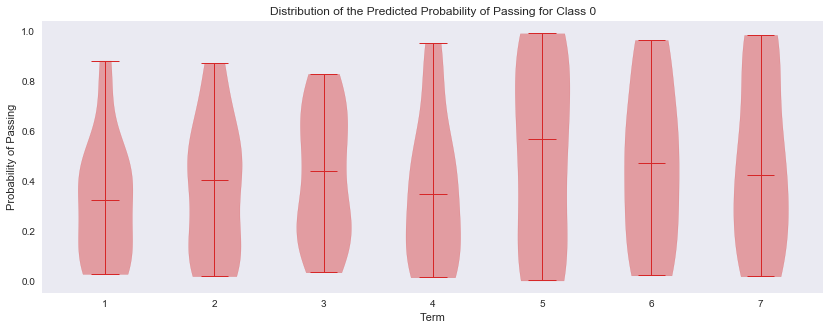

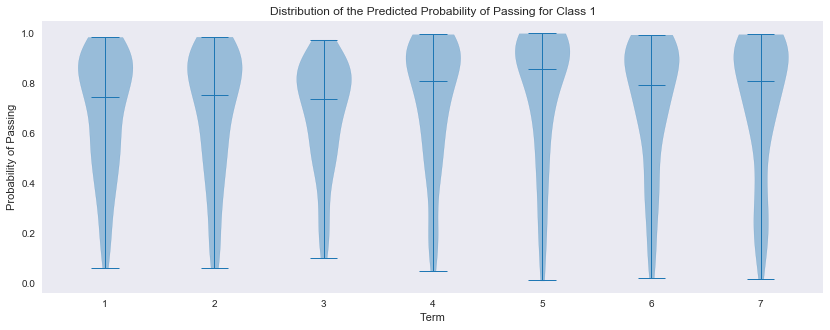

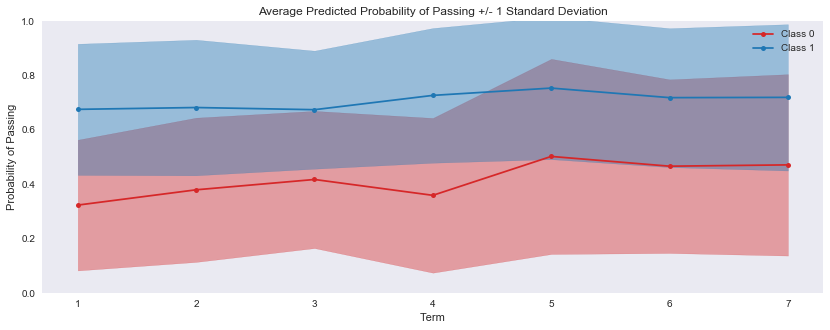

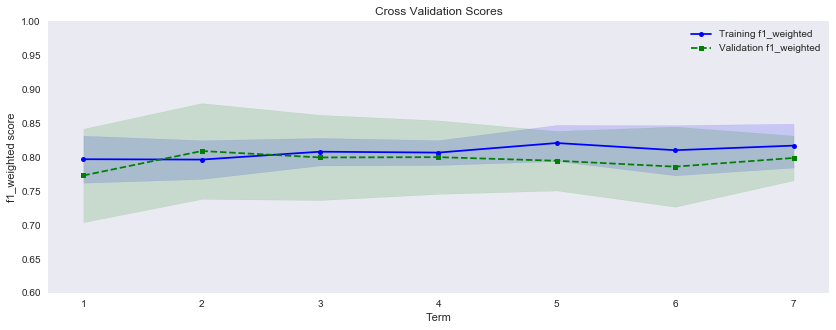

In [64]:
# Set parameters and initialize model
log_params = {'C':[1, 10, 100, 1000],
              'tol':[1e-1,1e-2,1e-3,1e-4],
              'penalty':['l1', 'l2'],
              'class_weight': ['balanced']
              }
log = LogisticRegression(n_jobs=-1)
fit_models(df_dict['combined'], 'x_train', 'y_train', 'x_test', 'y_test', log, log_params, 'f1_weighted', class_labels)

Model: LogisticRegression
Term: 1
Best Score: 75.46%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          14                5        
  Actual: Pass          38               82        

Classification Report:
             precision    recall  f1-score   support

          0       0.27      0.74      0.39        19
          1       0.94      0.68      0.79       120

avg / total       0.85      0.69      0.74       139



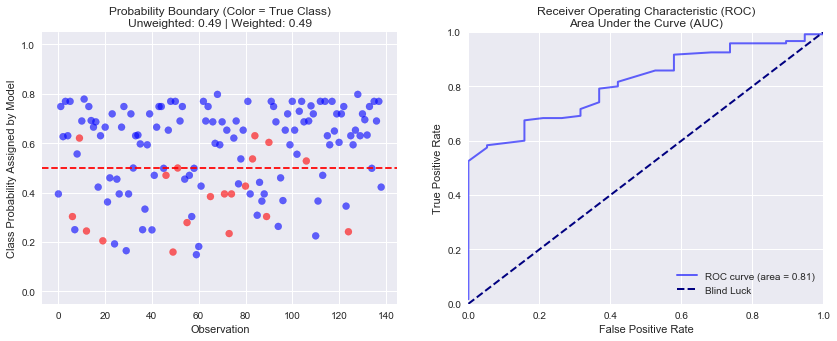

Term: 2
Best Score: 74.93%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          13                6        
  Actual: Pass          33               87        

Classification Report:
             precision    recall  f1-score   support

          0       0.28      0.68      0.40        19
          1       0.94      0.72      0.82       120

avg / total       0.85      0.72      0.76       139



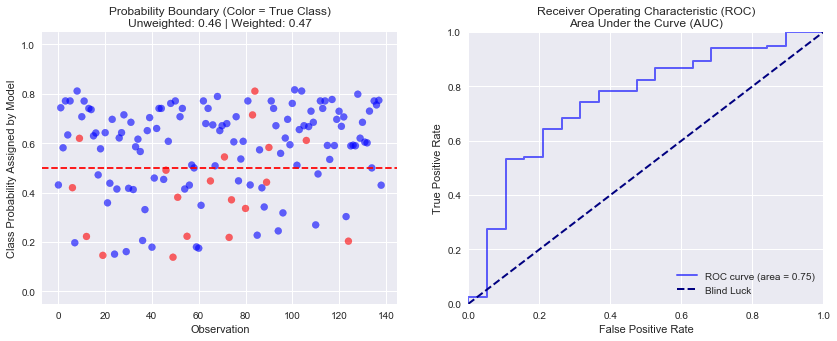

Term: 3
Best Score: 76.69%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          12                7        
  Actual: Pass          34               86        

Classification Report:
             precision    recall  f1-score   support

          0       0.26      0.63      0.37        19
          1       0.92      0.72      0.81       120

avg / total       0.83      0.71      0.75       139



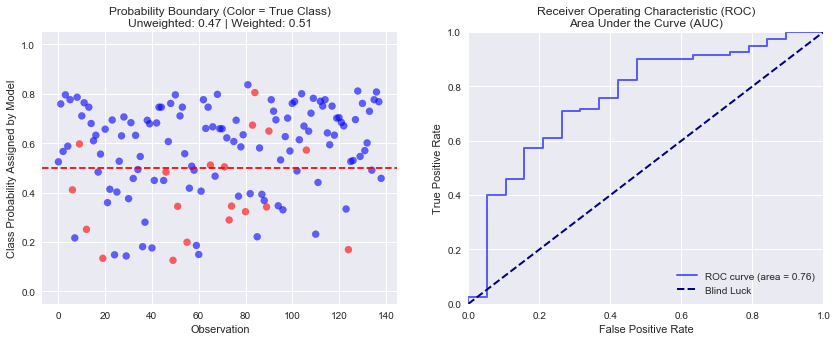

Term: 4
Best Score: 77.69%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          12                7        
  Actual: Pass          31               89        

Classification Report:
             precision    recall  f1-score   support

          0       0.28      0.63      0.39        19
          1       0.93      0.74      0.82       120

avg / total       0.84      0.73      0.76       139



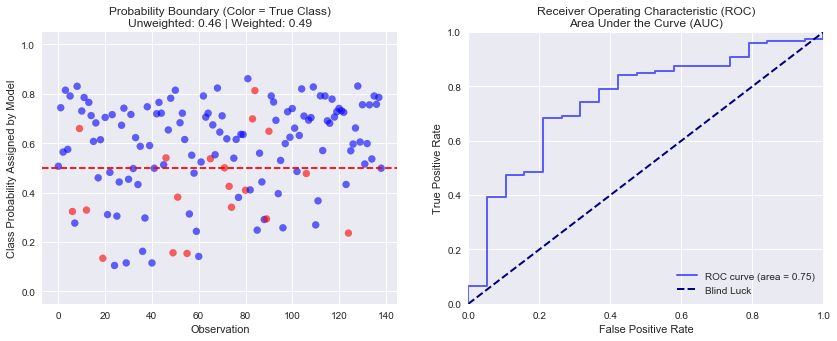

Term: 5
Best Score: 79.04%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          11                8        
  Actual: Pass          32               88        

Classification Report:
             precision    recall  f1-score   support

          0       0.26      0.58      0.35        19
          1       0.92      0.73      0.81       120

avg / total       0.83      0.71      0.75       139



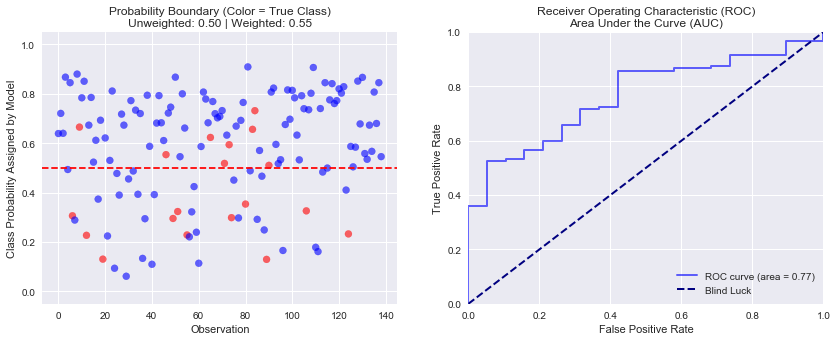

Term: 6
Best Score: 77.79%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          12                7        
  Actual: Pass          32               88        

Classification Report:
             precision    recall  f1-score   support

          0       0.27      0.63      0.38        19
          1       0.93      0.73      0.82       120

avg / total       0.84      0.72      0.76       139



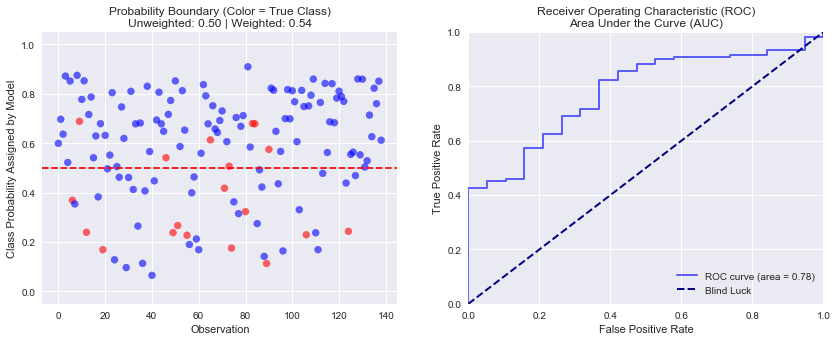

Term: 7
Best Score: 77.09%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          12                7        
  Actual: Pass          24               96        

Classification Report:
             precision    recall  f1-score   support

          0       0.33      0.63      0.44        19
          1       0.93      0.80      0.86       120

avg / total       0.85      0.78      0.80       139



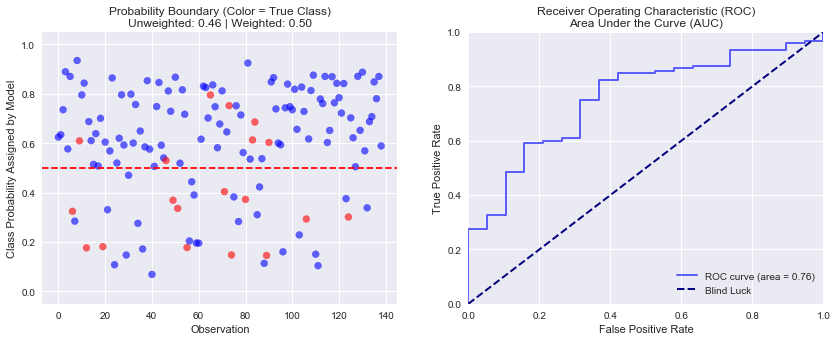

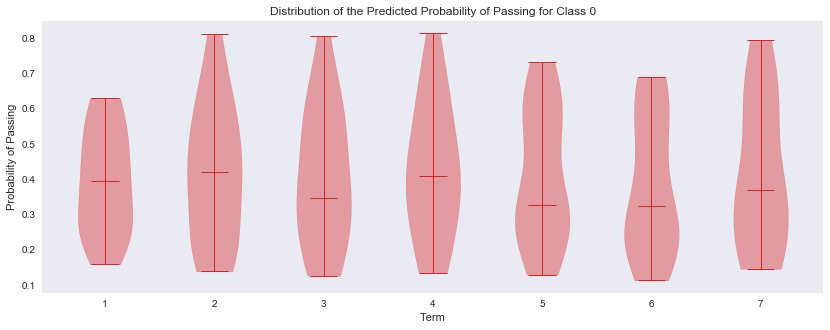

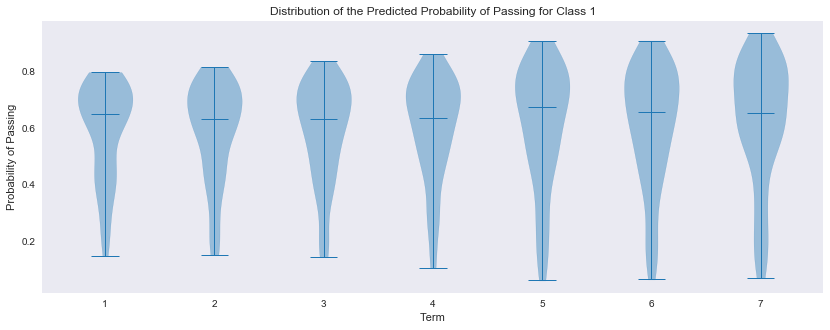

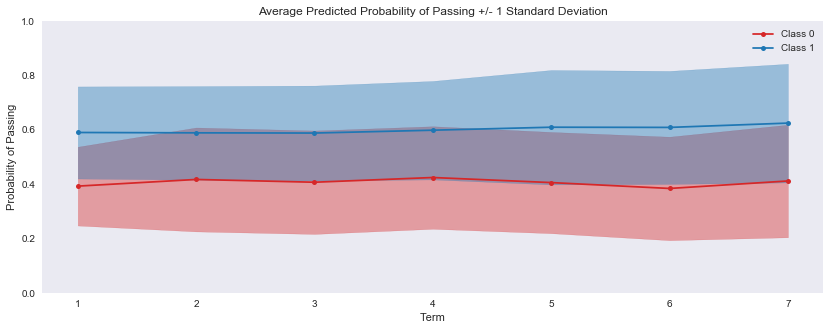

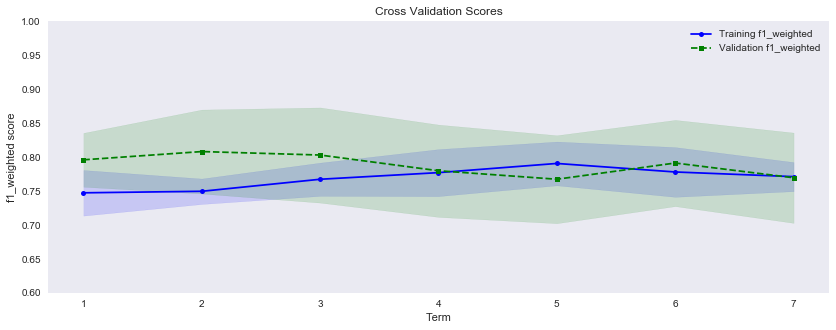

In [65]:
fit_models(df_dict['grades'], 'x_train', 'y_train', 'x_test', 'y_test', log, log_params, 'f1_weighted', class_labels)

Model: LogisticRegression
Term: 1
Best Score: 83.00%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          22               98        

Classification Report:
             precision    recall  f1-score   support

          0       0.31      0.53      0.39        19
          1       0.92      0.82      0.86       120

avg / total       0.83      0.78      0.80       139



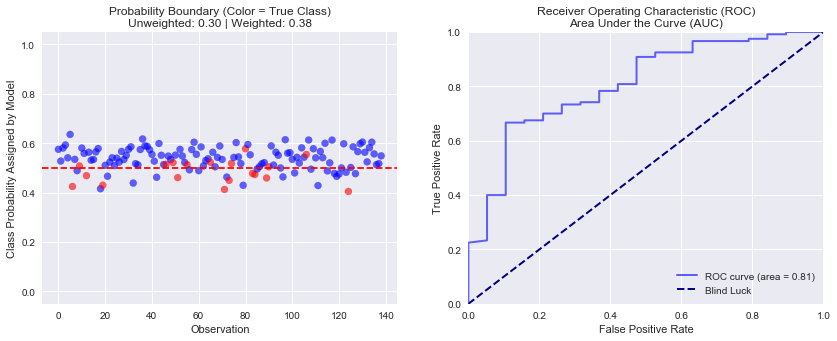

Term: 2
Best Score: 83.00%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          22               98        

Classification Report:
             precision    recall  f1-score   support

          0       0.31      0.53      0.39        19
          1       0.92      0.82      0.86       120

avg / total       0.83      0.78      0.80       139



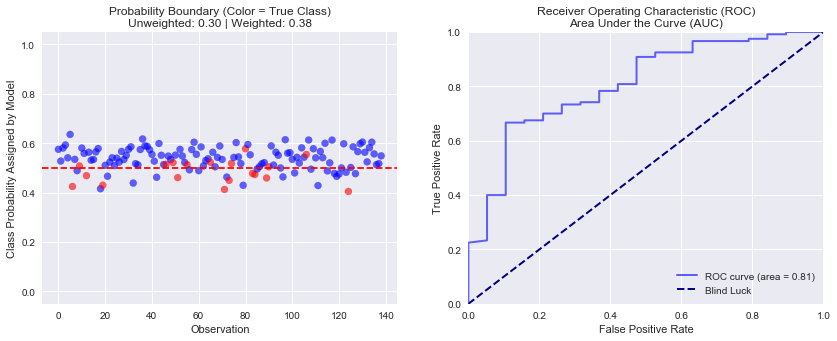

Term: 3
Best Score: 83.21%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          11                8        
  Actual: Pass          18               102       

Classification Report:
             precision    recall  f1-score   support

          0       0.38      0.58      0.46        19
          1       0.93      0.85      0.89       120

avg / total       0.85      0.81      0.83       139



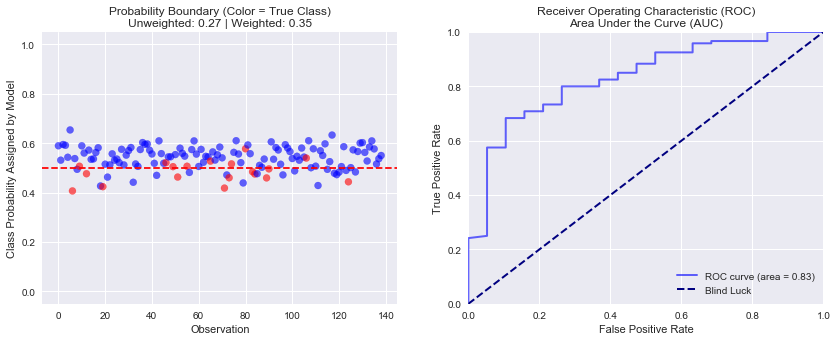

Term: 4
Best Score: 84.44%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          13                6        
  Actual: Pass          17               103       

Classification Report:
             precision    recall  f1-score   support

          0       0.43      0.68      0.53        19
          1       0.94      0.86      0.90       120

avg / total       0.88      0.83      0.85       139



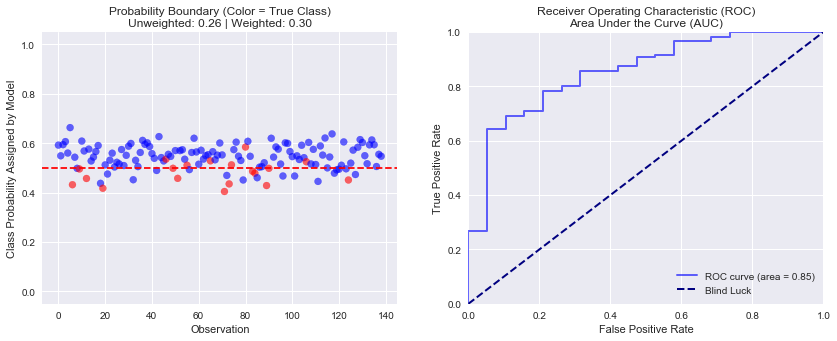

Term: 5
Best Score: 86.03%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          18               102       

Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.53      0.43        19
          1       0.92      0.85      0.88       120

avg / total       0.84      0.81      0.82       139



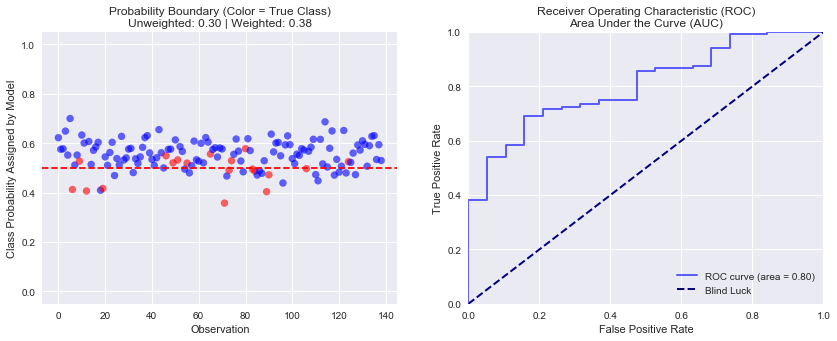

Term: 6
Best Score: 85.70%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail          10                9        
  Actual: Pass          19               101       

Classification Report:
             precision    recall  f1-score   support

          0       0.34      0.53      0.42        19
          1       0.92      0.84      0.88       120

avg / total       0.84      0.80      0.82       139



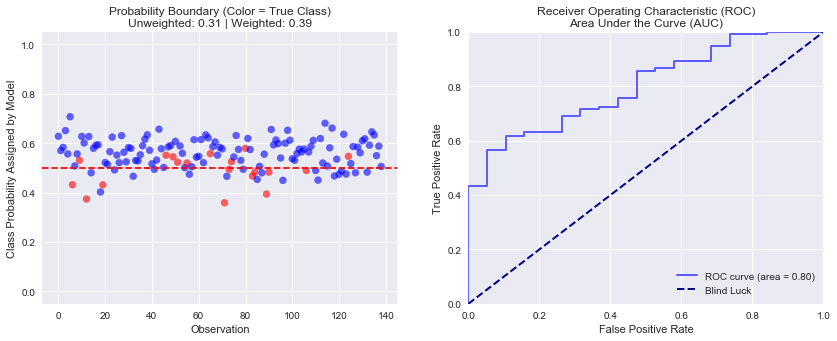

Term: 7
Best Score: 86.30%
Best Estimator: LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           9               10        
  Actual: Pass          19               101       

Classification Report:
             precision    recall  f1-score   support

          0       0.32      0.47      0.38        19
          1       0.91      0.84      0.87       120

avg / total       0.83      0.79      0.81       139



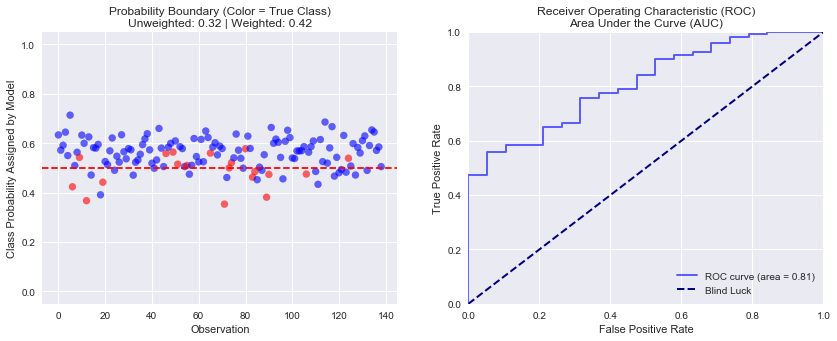

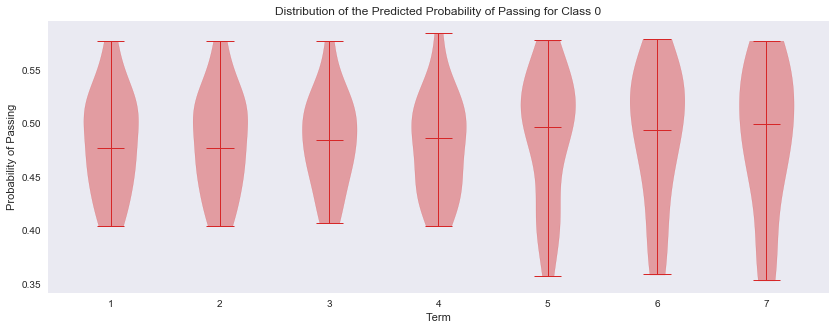

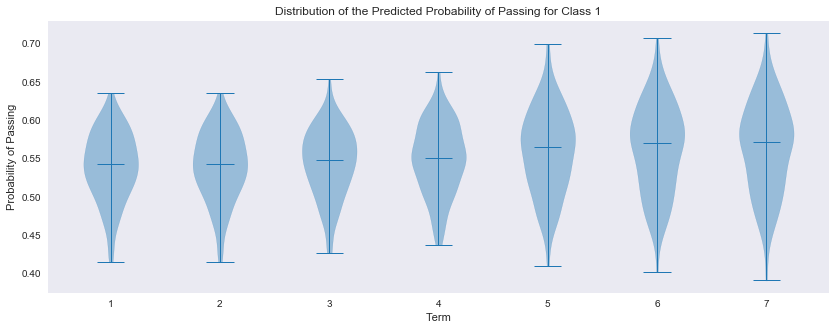

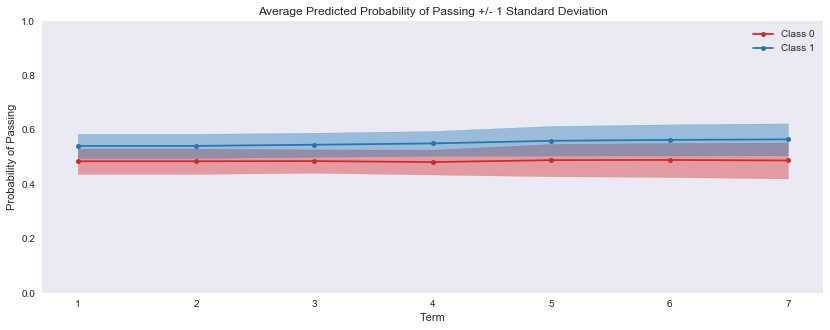

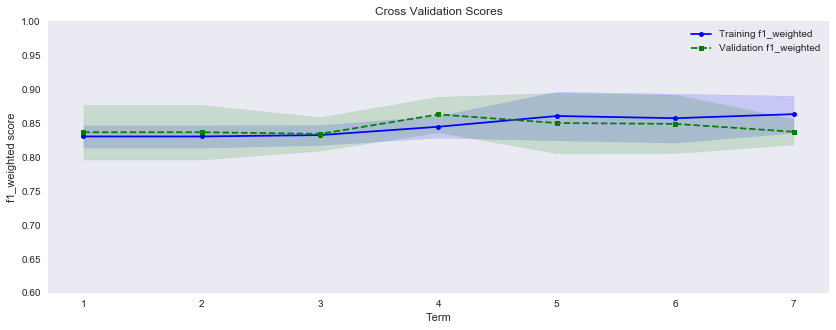

In [66]:
fit_models(df_dict['pa_dist'], 'x_train', 'y_train', 'x_test', 'y_test', log, log_params, 'f1_weighted', class_labels)

Model: AdaBoostClassifier
Term: 1
Best Score: 87.25%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=150, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           6               13        
  Actual: Pass          11               109       

Classification Report:
             precision    recall  f1-score   support

          0       0.35      0.32      0.33        19
          1       0.89      0.91      0.90       120

avg / total       0.82      0.83      0.82       139



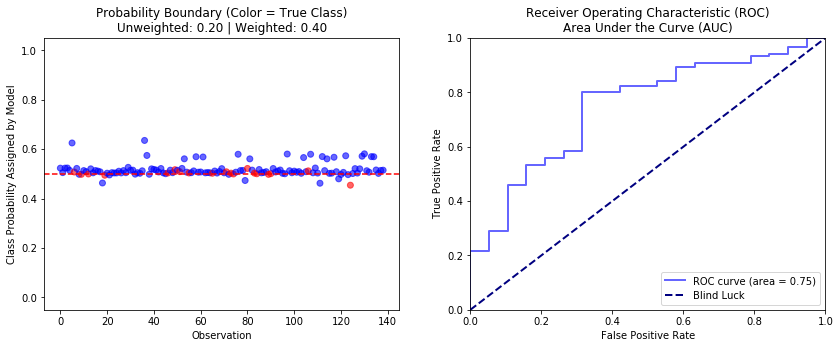

Term: 2
Best Score: 84.53%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           4               15        
  Actual: Pass          11               109       

Classification Report:
             precision    recall  f1-score   support

          0       0.27      0.21      0.24        19
          1       0.88      0.91      0.89       120

avg / total       0.80      0.81      0.80       139



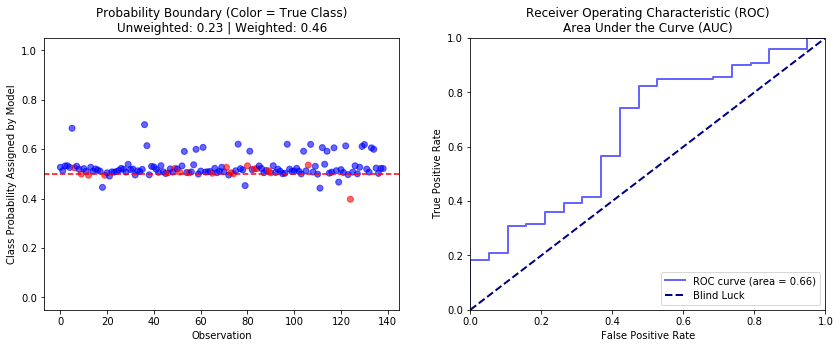

Term: 3
Best Score: 84.46%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=150, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           5               14        
  Actual: Pass          13               107       

Classification Report:
             precision    recall  f1-score   support

          0       0.28      0.26      0.27        19
          1       0.88      0.89      0.89       120

avg / total       0.80      0.81      0.80       139



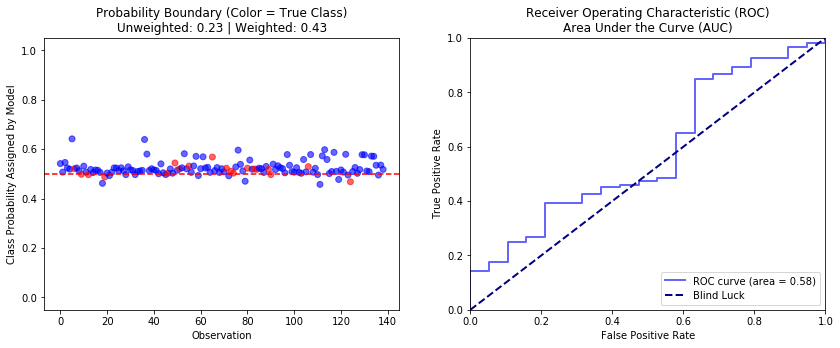

Term: 4
Best Score: 84.26%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=150, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           3               16        
  Actual: Pass          11               109       

Classification Report:
             precision    recall  f1-score   support

          0       0.21      0.16      0.18        19
          1       0.87      0.91      0.89       120

avg / total       0.78      0.81      0.79       139



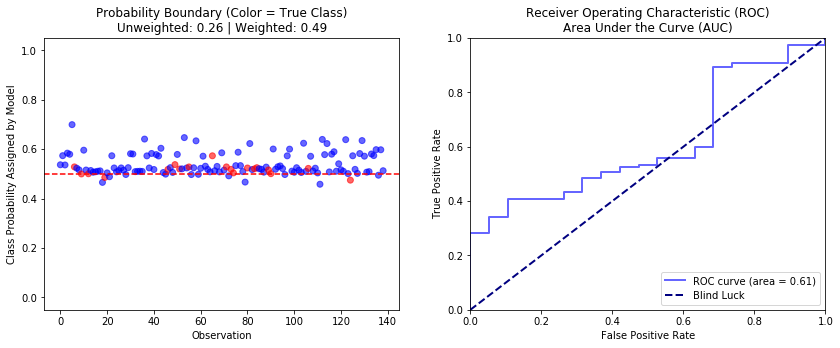

Term: 5
Best Score: 84.60%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           4               15        
  Actual: Pass           9               111       

Classification Report:
             precision    recall  f1-score   support

          0       0.31      0.21      0.25        19
          1       0.88      0.93      0.90       120

avg / total       0.80      0.83      0.81       139



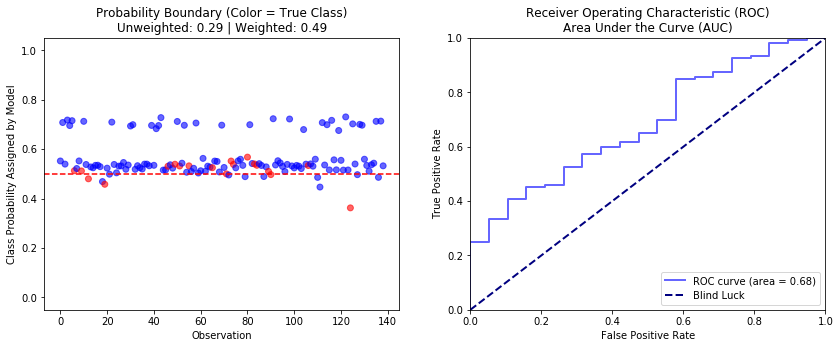

Term: 6
Best Score: 84.36%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           6               13        
  Actual: Pass           9               111       

Classification Report:
             precision    recall  f1-score   support

          0       0.40      0.32      0.35        19
          1       0.90      0.93      0.91       120

avg / total       0.83      0.84      0.83       139



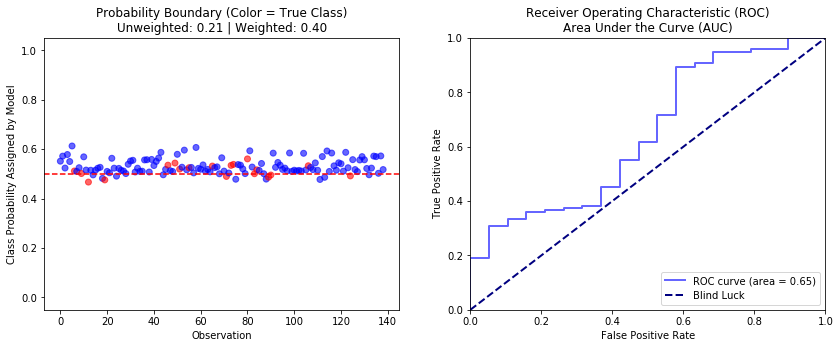

Term: 7
Best Score: 85.81%
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=25)

Confusion Matrix:
                  Predicted: Fail  Predicted: Pass 
  Actual: Fail           3               16        
  Actual: Pass          11               109       

Classification Report:
             precision    recall  f1-score   support

          0       0.21      0.16      0.18        19
          1       0.87      0.91      0.89       120

avg / total       0.78      0.81      0.79       139



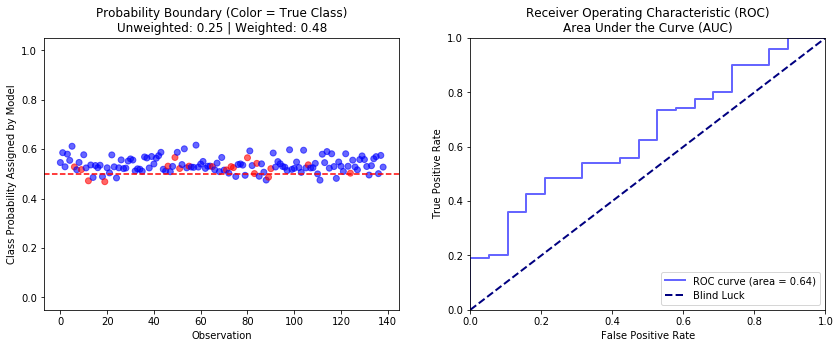

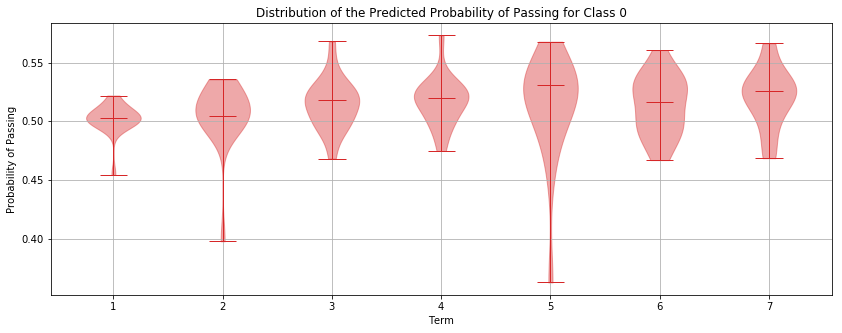

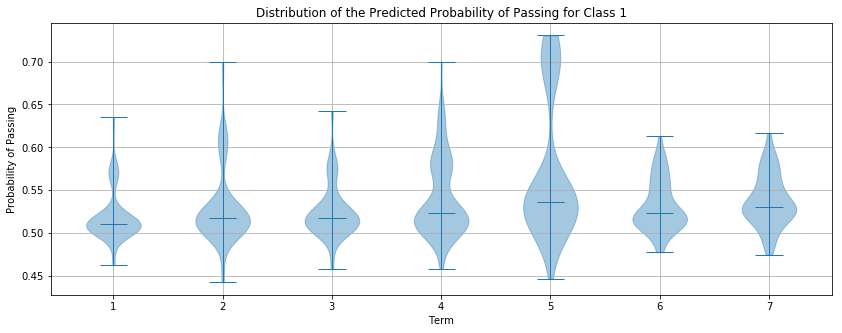

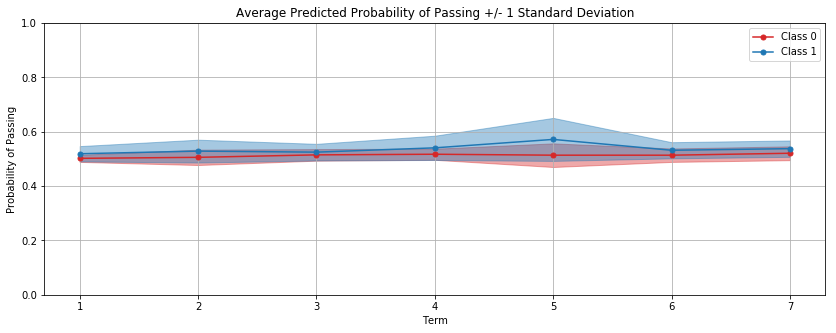

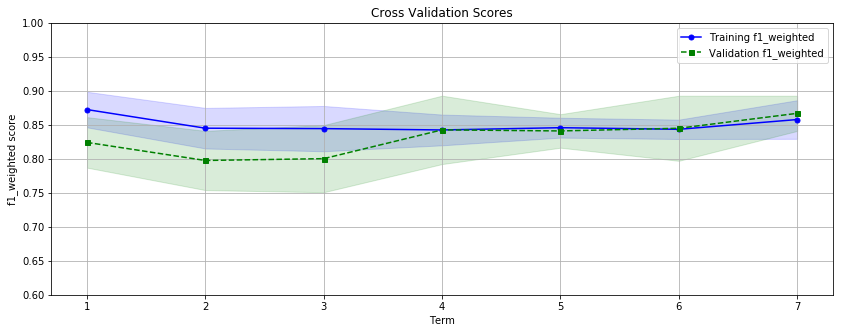

In [92]:
# Set parameters and initialize model
ada_params = [
    {'n_estimators':[50,100,150,200,250,300,350,400],
     'learning_rate':[1.0,2.0,3.0]
    }
]
ada = AdaBoostClassifier(random_state=25)
fit_models(df_dict['combined'], 'x_train', 'y_train', 'x_test', 'y_test', ada, ada_params, 'f1_weighted', class_labels)

In [21]:
df_types = ['combined', 'grades', 'pa_dist']

In [ ]:
for t in df_types:
    df_dict[t]

In [67]:
test = df_dict['combined'][3]['LogisticRegression']

In [68]:
test.keys()

dict_keys(['terms', 'test_scores', 'train_mean', 'scoring_method', 'combined_probs', 'test_std', 'train_scores', 'pred_prob', 'pred', 'train_std', 'target', 'test_mean', 'estimator'])

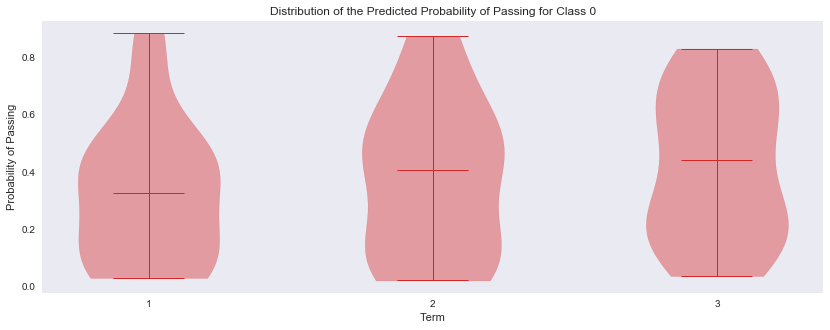

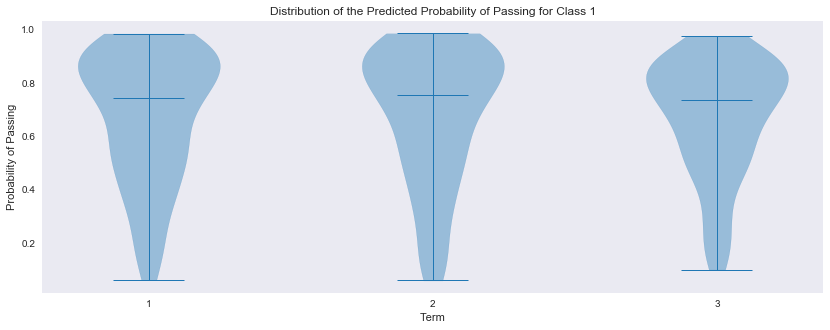

In [69]:
plot_violins(test['terms'], test['combined_probs'], test['target'])

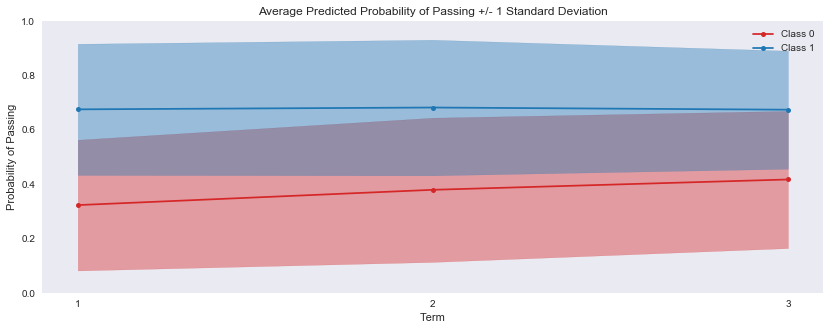

In [73]:
plot_error_bars(test['terms'], test['combined_probs'], test['target'])

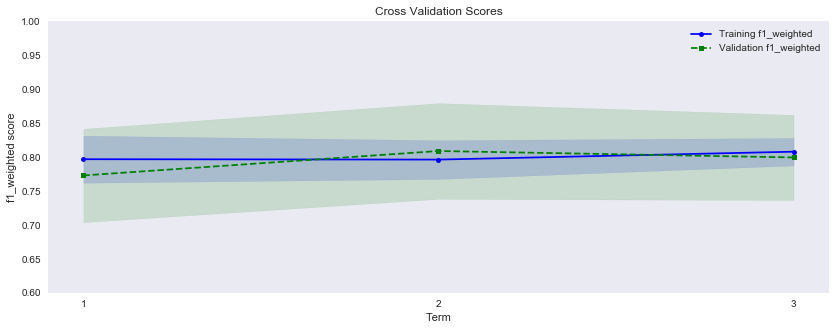

In [74]:
plot_cross_validation(test['terms'], test['train_mean'], test['train_std'], test['test_mean'], test['test_std'], test['scoring_method'])

In [ ]:
# Gather prediction probabilities into a single array, organized by observation
combined_probs = combine_probs_by_term(data_dict, terms, predict_prob)
target = np.array(data_dict[1][val_y])

# Violin plots
plot_violins(combined_probs, target)

# Plot error bars
plot_error_bars(terms, combined_probs, target)

# Plot the training and validation scores with standard deviation
plot_cross_validation (terms, train_mean, train_std, test_mean, test_std, scoring_method)



text output
    


subplots x wide (max 3)
    violin
    error
    cross validation

In [99]:
x = 0
y = 0
s = '''Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139'''

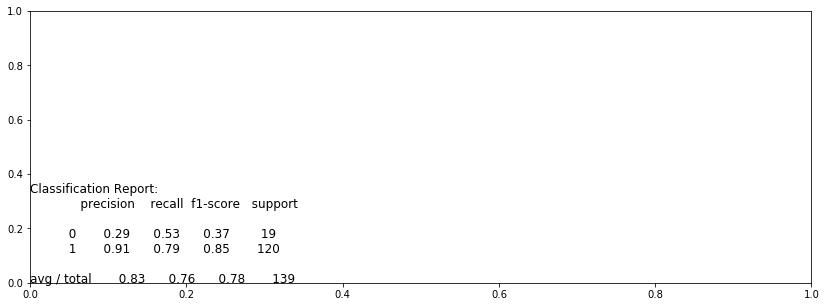

In [100]:
plt.text(x, y, s, fontsize=12)

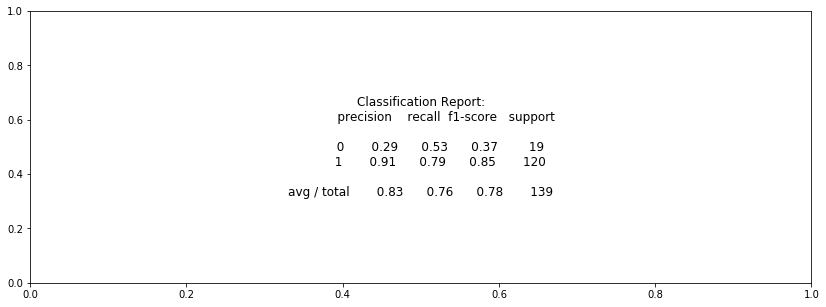

In [103]:
plt.text(0.5, 0.5,s, horizontalalignment='center',verticalalignment='center', fontsize=12)

In [98]:
print('''Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139''')

Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139


In [6]:
# Pickle the data for future use
with open('df_dict.pickle', 'wb') as f:
    pickle.dump(df_dict, f, pickle.HIGHEST_PROTOCOL)